In [194]:
%matplotlib inline
import matplotlib as mpl
font_cache_path = mpl.get_cachedir() + '/fontList.cache'
%rm $font_cache_path
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

import pandas as pd

rm: /Users/arimuraterutoshi/.matplotlib/fontList.cache: No such file or directory


In [195]:
# あやめの機械学習用データをcsv形式で読み込む
df = pd.read_csv('https://archive.ics.uci.edu/ml/'
        'machine-learning-databases/iris/iris.data', header=None)
df.tail()

,0,1,2,3,4
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


In [196]:
def plot_decision_regions(X, y, classifier, resolution=0.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

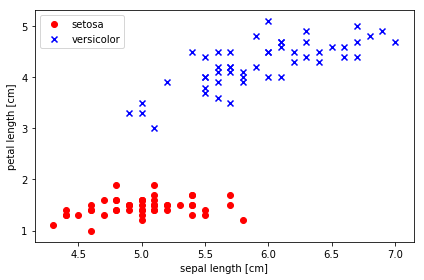

In [197]:
# setosaとversicolorで目的変数を区別
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', -1, 1)

# epal lengthとpetal lengthをXに格納
X = df.iloc[0:100, [0, 2]].values

# plot data
plt.scatter(X[:50, 0], X[:50, 1],
            color='red', marker='o', label='setosa')
plt.scatter(X[50:100, 0], X[50:100, 1],
            color='blue', marker='x', label='versicolor')

plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('./images/02_06.png', dpi=300)
plt.show()



In [198]:
# 平均0の分散1になるように事前処理を行う
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

# 動作確認

In [199]:
# 事前処理された入力データの確認
X_std[:3]

array([[-0.5810659 , -1.01435952],
       [-0.89430898, -1.01435952],
       [-1.20755205, -1.08374115]])

In [200]:
# パラメータを初期化
w_ = np.zeros(1 + X_std.shape[1])
w_

array([ 0.,  0.,  0.])

In [201]:
# 初期のパラメータ 0徐算しないように初期値に小さい値を入れている
hl = pow(10, -8)
hl

1e-08

In [202]:
# 初期の学習率
eta = 0.01

In [203]:
output = np.dot(X_std, w_[1:]) + w_[0]
output[:3]

array([ 0.,  0.,  0.])

In [204]:
cost = []
for xi, target in zip(X_std, y):
    output = np.dot(xi, w_[1:]) + w_[0]
    error = (target - output)
    hl = hl + (xi.dot(error) * xi.dot(error)).sum()
    w_[1:] += eta * xi.dot(error) / (np.sqrt(hl))
    w_[0] += eta * error.sum() / (np.sqrt(hl))
    cost.append(0.5 * error**2)
print(sum(cost) / len(y))

0.390147778833


In [205]:
# 20回ほど繰り返して学習
for i in range(20):
    cost = []
    # パラメータ初期化
    hl = pow(10, -5)
    # トレーニングデータをシャッフル
    r = np.random.permutation(len(y))
    X_std, y = X_std[r], y[r]
    for xi, target in zip(X_std, y):
        output = np.dot(xi, w_[1:]) + w_[0]
        error = (target - output)
        hl = hl + (xi.dot(error) * xi.dot(error)).sum()
        w_[1:] += eta * xi.dot(error) / (np.sqrt(hl))
        w_[0] += eta * error.sum() / (np.sqrt(hl))
        cost.append(0.5 * error**2)
    #print(sum(cost) / len(y))

In [206]:
class AdaGrad(object):
    def __init__(self, eta=0.01, n_iter=50, h0=pow(10, -8) ):
        self.eta = eta
        self.n_iter = n_iter
        self.h0 = h0
        self.hl = h0

    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            cost = []
            # トレーニングデータをシャッフル
            X, y = self._shuffle(X, y)
            for xi, target in zip(X, y):
                output = self.activation(xi)
                # 誤差を算出
                errors = (target - output)
                self.hl = self.hl + (errors * errors)
                #self.hl = self.hl + (error * error)
                self.w_[1:] += self.eta * xi.dot(errors) / (np.sqrt(self.hl))
                self.w_[0] += self.eta * errors / (np.sqrt(self.hl))
                #self.w_[1:] += self.eta * xi.T.dot(error)
                #self.w_[0] += self.eta * errors
                cost.append(0.5 * errors**2)
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.0, 1, -1)
    
    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = np.random.permutation(len(y))
        return X[r], y[r]


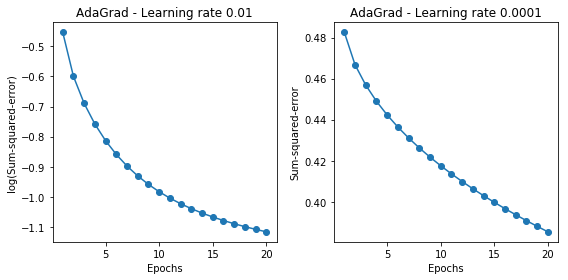

In [207]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

ada1 = AdaGrad(n_iter=20, eta=0.01, h0=pow(10, -8)).fit(X_std, y)
ax[0].plot(range(1, len(ada1.cost_) + 1), np.log10(ada1.cost_), marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Sum-squared-error)')
ax[0].set_title('AdaGrad - Learning rate 0.01')

ada2 = AdaGrad(n_iter=20, eta=0.001, h0=pow(10, -8)).fit(X_std, y)
ax[1].plot(range(1, len(ada2.cost_) + 1), ada2.cost_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Sum-squared-error')
ax[1].set_title('AdaGrad - Learning rate 0.0001')

plt.tight_layout()
# plt.savefig('./adaline_1.png', dpi=300)
plt.show()

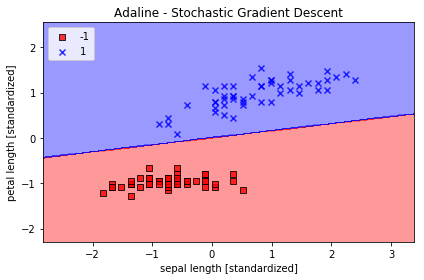

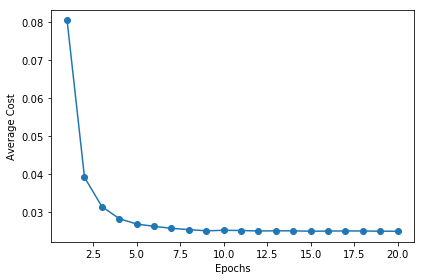

0/100


In [210]:
# adagradの場合は学習率が大きくてもエラーの数は減り続ける
ada = AdaGrad(n_iter=20, eta=0.1, h0=pow(10, -8))
ada.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada)
plt.title('Adaline - Stochastic Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('./adaline_4.png', dpi=300)
plt.show()

plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average Cost')

plt.tight_layout()
# plt.savefig('./adaline_5.png', dpi=300)
plt.show()
error_count = 0
for xi, target in zip(X_std, y):
    if ada.predict(xi) != target:
        error_count = error_count + 1
print(str(error_count ) + "/" + str(len(y)))

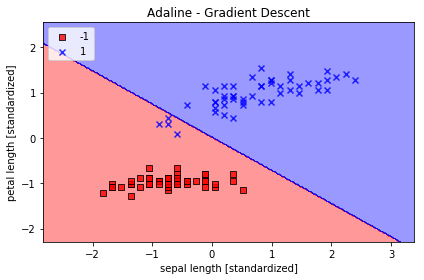

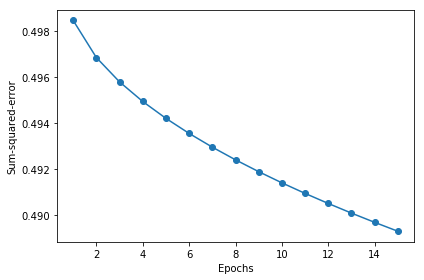

4/100


In [209]:
ada = AdaGrad(n_iter=15, eta=0.0001, h0=pow(10, -8))
ada.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada)
plt.title('Adaline - Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('./adaline_2.png', dpi=300)
plt.show()

plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')

plt.tight_layout()
# plt.savefig('./adaline_3.png', dpi=300)
plt.show()

error_count = 0
for xi, target in zip(X_std, y):
    if ada.predict(xi) != target:
        error_count = error_count + 1
print(str(error_count ) + "/" + str(len(y)))